# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
from sklearn.cluster import KMeans, AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
df = pd.merge(df_offers, df_transactions)
matrix = df.pivot_table(index='customer_name', columns='offer_id', values='n')
matrix = matrix.fillna(0).reset_index()
matrix.tail()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
95,Williams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
96,Wilson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
97,Wood,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
98,Wright,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
99,Young,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
    For a given value of k, a lower SS represents a better clustering, because it means the centroids are closer to the
    data that they represent.
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

### Exercise: What values of SS do you believe represent better clusterings? Why? 
* For a given value of k, a lower SS represents a better clustering, because it means the centroids are closer to the 
data that they represent.  
* When k is allowed to vary, in general a lower SS would represent a better clustering; however, the 
SS will decrease with increasing k (unless we choose really bad centroids). Thus, we have to use other methods (domain
expertise or the methods we're doing now) to choose an appropriate k.  (Otherwise we would just choose k = our number of 
samples with a SS of zero, which would make clustering pointless.)

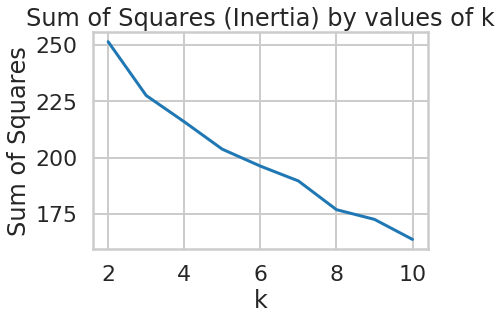

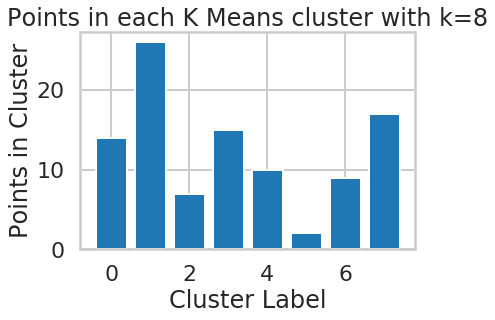

In [5]:
# your turn
x_cols = matrix.columns[1:]

# Initialize list and calculate sum of squares for k-means with k from 2 to 10
sum_squares_list = []
possible_ks = range(2,11)

for k in possible_ks:
    clf = KMeans(n_clusters=k, random_state=51)
    clf.fit(matrix[x_cols])
    sum_squares_list.append(clf.inertia_)
    
# Chart
plt.plot(possible_ks, sum_squares_list)
plt.title('Sum of Squares (Inertia) by values of k')
plt.xlabel('k')
plt.ylabel('Sum of Squares')
plt.show()

# Choose best k as 8 and re-fit K Means, assigning labels
clf = KMeans(n_clusters=8)
labeled = clf.fit_predict(matrix[x_cols])

# Chart
plt.bar(list(range(8)), np.bincount(labeled))
plt.title('Points in each K Means cluster with k=8')
plt.xlabel('Cluster Label')
plt.ylabel('Points in Cluster')
plt.show()

### Exercise: What challenges did you experience using the Elbow method to pick K? 
* Most charts really didn't have a defined 'elbow'. I essentially chose 8 by running the loop 2 <= K <= 10 a bunch of 
times and choosing the number that seemed to have a decent elbow more often than other values of k.
* Because the clusters change each time, even if there was a good elbow, the lack of stability of the algorithm 
undermines my confidence with it in a case like this.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.09365573283492713
For n_clusters = 3 The average silhouette_score is : 0.11889942863638556
For n_clusters = 4 The average silhouette_score is : 0.12347053919571699
For n_clusters = 5 The average silhouette_score is : 0.14092516241984757
For n_clusters = 6 The average silhouette_score is : 0.1371798939109807
For n_clusters = 7 The average silhouette_score is : 0.1161092456616906
For n_clusters = 8 The average silhouette_score is : 0.11339573832632867
For n_clusters = 9 The average silhouette_score is : 0.12505960527779877
For n_clusters = 10 The average silhouette_score is : 0.11928332134753233


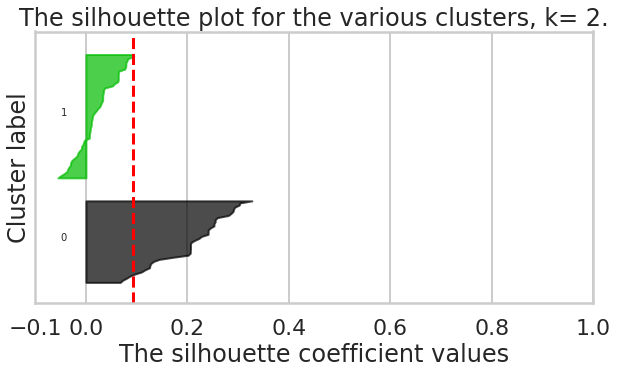

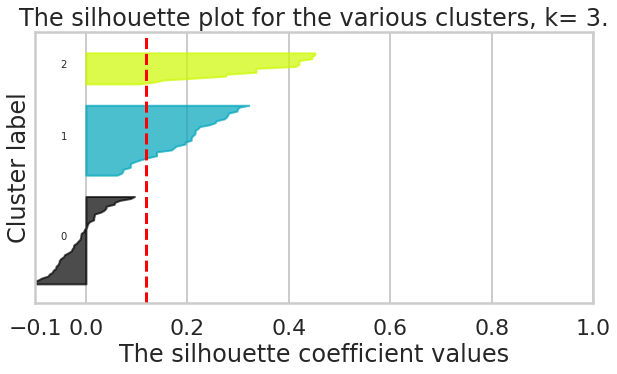

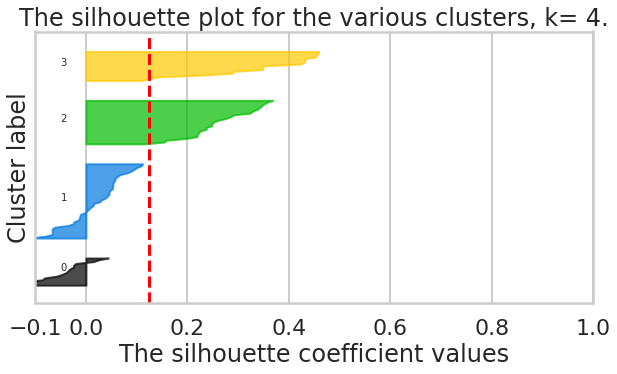

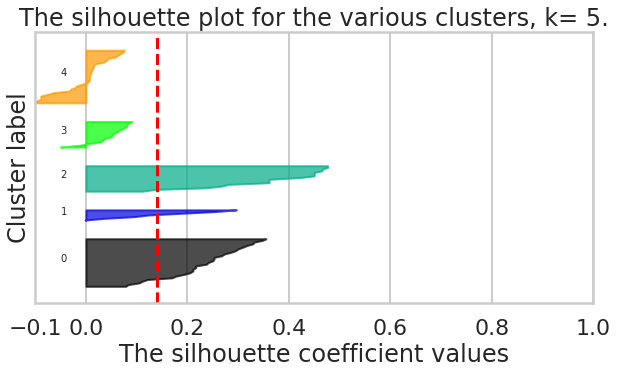

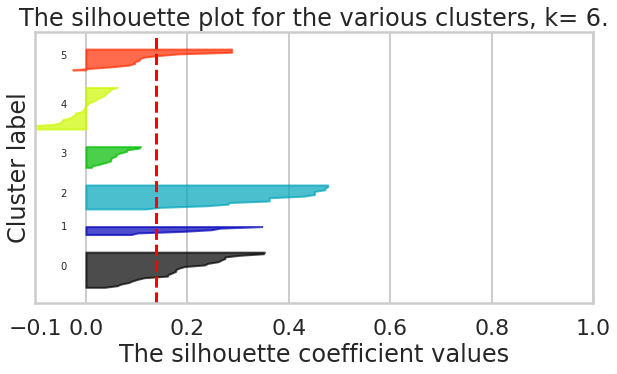

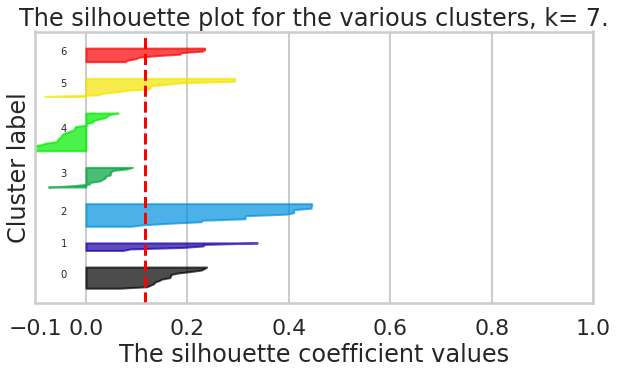

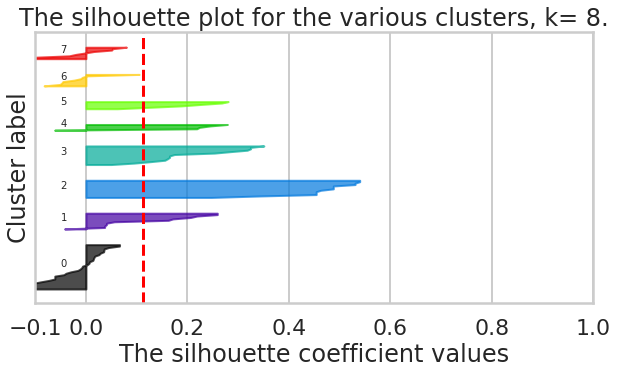

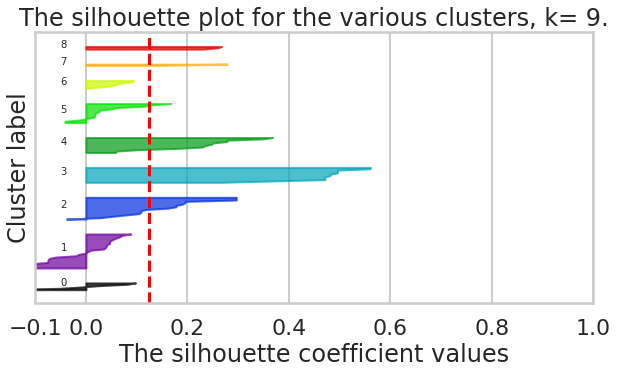

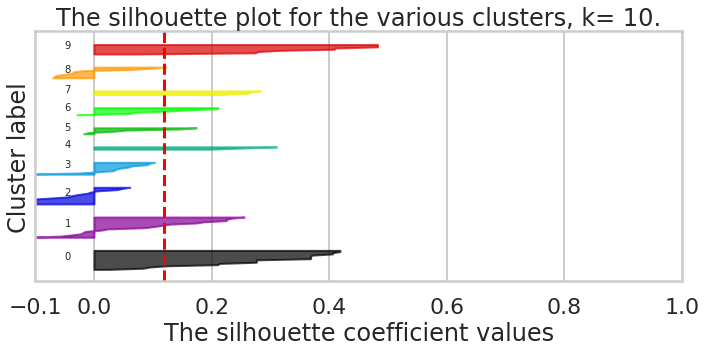

In [6]:
# Your turn.

# Code taken from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html and 
# modified slightly.

range_n_clusters = list(range(2,11))

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    #fig, (ax1, ax2) = plt.subplots(1, 2)
    fig, ax1 = plt.subplots()
    fig.set_size_inches(10, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(matrix[x_cols]) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(matrix[x_cols])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = sklearn.metrics.silhouette_score(matrix[x_cols], cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(matrix[x_cols], cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters, k= " + str(n_clusters) + ".")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


plt.tight_layout()
plt.show()

### Exercise: Compute the average silhouette score for each K and plot it. What K does the plot suggest we should choose? Does it differ from what we found using the Elbow method?
The average silhouette plot (below) suggests k=5 would be a reasonable choice. That differs from what the Elbow method 
often suggested, when it suggested a reasonable choice at all.

Text(0, 0.5, 'Average Silhouette Score')

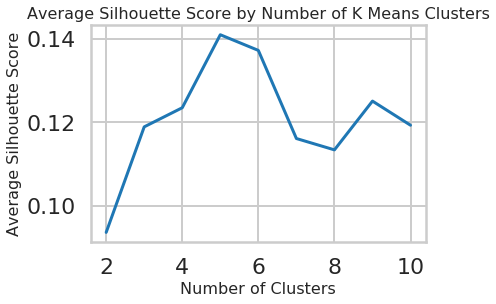

In [7]:
range_n_clusters = list(range(2,11))

avgs = []
for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(matrix[x_cols])
    silhouette_avg = sklearn.metrics.silhouette_score(matrix[x_cols], cluster_labels)
    avgs.append(silhouette_avg)

plt.plot(range_n_clusters, avgs)
plt.title('Average Silhouette Score by Number of K Means Clusters', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=16)
plt.ylabel('Average Silhouette Score', fontsize=16)

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

### Exercise: How do the clusters look? Based on what you see, what seems to be the best value for K ? Moreover, which method of choosing K seems to have produced the optimal result visually? 
When I ran the clusters with k=8 (which I picked from my elbow graph above), there was little rhyme or reason to the clusters.  You really couldn't even tell them apart.

Running the clusters with k=5 as below, the clusters mostly seem to make sense. There's a group at the top, a group at
the right, a group at the left, and two overlapping groups at the bottom of the chart.  When you look just at the chart,
it looks like groups 2 and 3 overlap so much that maybe they should go together.  We'll see later that there are some
noticeable differences between groups 2 and 3.

So, I think 5 is the best value for k, and PCA created these clusters.

Text(0.5, 0.98, 'Customers Grouped by Cluster')

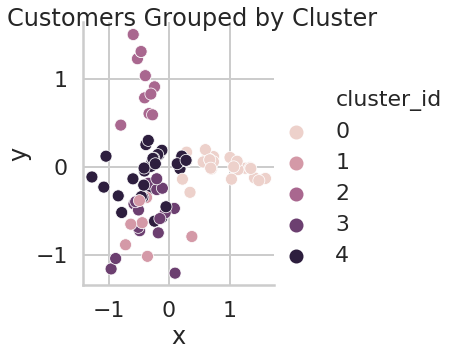

In [8]:
#your turn
pca = PCA(n_components=2)
x_new = pca.fit_transform(matrix[x_cols])

clusterer = KMeans(n_clusters=5, random_state=10)
cluster_labels = clusterer.fit_predict(matrix[x_cols])

# Create the dataframe with all the columns
#matrix['cluster_id'] = labeled
matrix['cluster_id'] = cluster_labels
matrix['x'] = x_new[:,0]
matrix['y'] = x_new[:,1]

# Chart
ax = sns.relplot(x='x', y='y', hue='cluster_id', data=matrix, legend='full')
ax.fig.suptitle('Customers Grouped by Cluster', fontsize=24)

### Exercise: Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?
The clusters have 'tendencies', but there are very few 'smoking guns' in this data -- it's mostly a matter of taking the
tendencies together.

I constructed the charts by grouping the dataset by cluster, and examining within each cluster, which characteristics are
shown in at least 10% of that cluster.  (Also note that every group drinks a lot of wines from France, so I won't mention 
it since that doesn't distinguish any cluster.)

Looking at the charts below:
* Group 0: drinks Espumante, Prosecco, Malbec, and Pinot Grigio. Likes wines from Australia, Oregon, and South Africa. 
Buys more often in fall and winter. Not particularly price sensitive, but most often buys in small quantities.
* Group 1: drinks Champagne, Prosecco, and Espumante. Likes wines from Chile and New Zealand. Buys more often during the
Summer and Winter campaigns. Not very price-sensitive, and buys 'past peak' often. Typically buys at least 72 or 144.
* Group 2: drinks Pinot Noir *almost exclusively*. Likes wines from Australia, Italy, and Germany. Buys most often during
the Fall campaigns. The most price-sensitive, but almost never buys 'past peak'. Buying quantities vary widely.
* Group 3: drinks Champagne, Prosecco, and Cabernet Sauvignon. Buys more French wine than any other group; also likes 
Chilean wines. Buys fairly consistently throughout the year, is very price-sensitive, and usually buys at least 72.
* Group 4: drinks Champagne and Cabernet Sauvignon. Likes French and Chilean wines, and buys throughout the year. The 
discount level doesn't impact their purchasing much, and they buy in bulk (72 or 144).

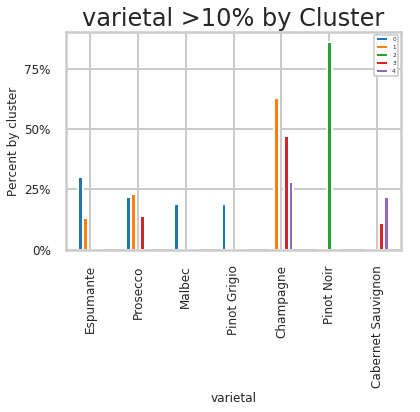

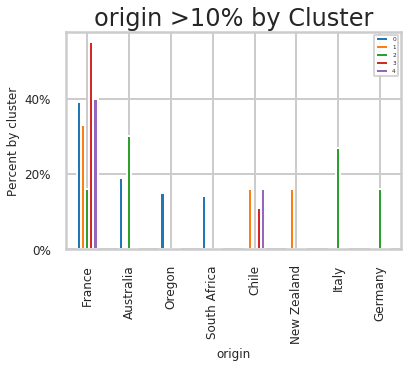

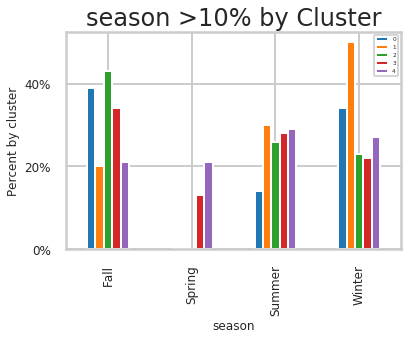

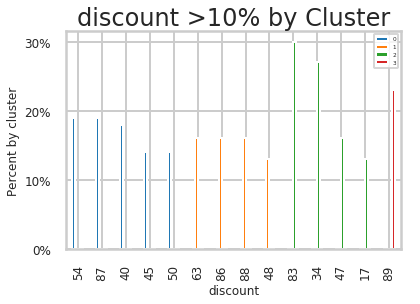

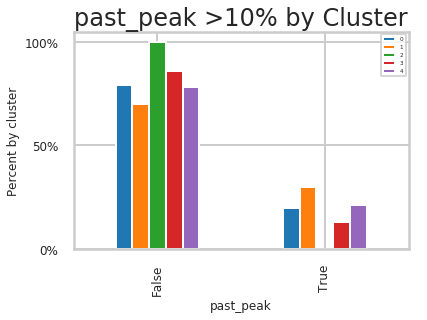

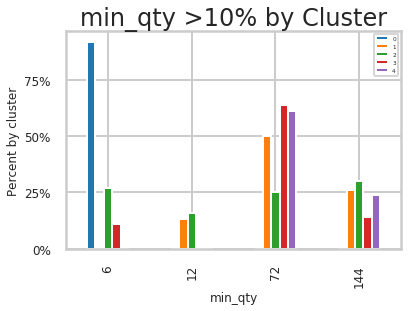

In [9]:
customer_clusters = matrix[['customer_name', 'cluster_id', 'x', 'y']]
df2 = pd.merge(df_transactions, customer_clusters)
df2 = pd.merge(df_offers, df2)

# Add a column 'season' to the dataframe for easier visualization
df2.loc[(df2.campaign == 'January') | (df.campaign == 'February') | (df2.campaign == 'March'), 'season'] = 'Winter'
df2.loc[(df2.campaign == 'April') | (df.campaign == 'May') | (df2.campaign == 'June'), 'season'] = 'Spring'
df2.loc[(df2.campaign == 'June') | (df.campaign == 'July') | (df2.campaign == 'August'), 'season'] = 'Summer'
df2.loc[(df2.campaign == 'October') | (df.campaign == 'November') | (df2.campaign == 'December'), 'season'] = 'Fall'

def plot_cluster_tendencies(dataframe, column):
    """Plots cluster tendencies by column.  Takes dataframe, groups by cluster_id, and plots on 'column' values > 10%.
    Input: a dataframe with a column *column* and a column 'cluster_id'.
    Output: no return value. Plots the >10% values in *column* by cluster_id."""
    
    percents = 100*dataframe.groupby('cluster_id')[column].value_counts()// dataframe.groupby('cluster_id')[column].count()
    ax = percents[percents.values > 10].unstack('cluster_id').plot(kind='bar')
    ax.set_title(column + ' >10% by Cluster')
    ax.legend(fontsize='xx-small', loc='best')
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel('Percent by cluster', fontsize=12)
    ax.set_yticklabels(['{:.0f}%'.format(x) for x in ax.get_yticks()], fontsize=12)
    ax.set_xticklabels((x for x in ax.get_xticklabels()), fontsize=12)

for c in ['varietal', 'origin', 'season', 'discount', 'past_peak', 'min_qty']:
    plot_cluster_tendencies(df2, c)

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

### Exercise: Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?
On this chart, after playing with the data, I'd choose 7 if I didn't have any other reason not to. 

4 looks like a good choice and 7 only gets you a few extra 
percent, for 75% more complexity, but this data set has a lot of subtlety. One reason not to use 7 would be if the 
business wanted to focus on fewer groups to minimize complexity in their campaigns, at the expense of some efficiency in their marketing spending.

(1, 10)

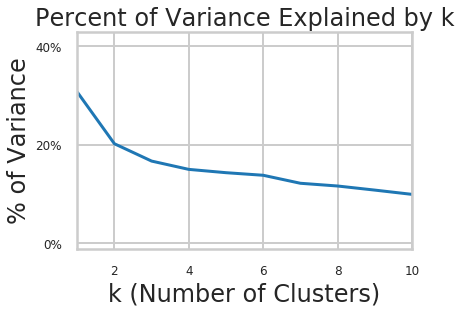

In [10]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(matrix[x_cols])

# Do the rest on your own :)
fig, ax = plt.subplots()
ax.plot(pca.explained_variance_)
ax.set_xticks(list(range(0,32,2)))
ax.set_xticklabels((x for x in ax.get_xticks()), fontsize=12)
ax.set_yticklabels(['{:.0f}%'.format(100*x) for x in ax.get_yticks()], fontsize=12)
ax.set_title('Percent of Variance Explained by k')
ax.set_xlabel('k (Number of Clusters)')
ax.set_ylabel('% of Variance')
ax.set_xlim(1,10)

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


### Exercise: How do their results compare? Which performs the best? Tell a story why you think it performs the best.
Notes:
* It's hard to 'stack-rank' the results, given that our dataset does not have obvious correct clusters.
* Although choosing a number of clusters k in advance is wonky and feels a little arbitrary, the algorithms that require
a k parameter are actually easier to work with and tune - you have an idea of what to expect when you run it.
* Affinity propagation has some areas that look good (the points above y=1 in the chart below are all in the same 
cluster), but there are too many groupings of close points that are in different clusters for my comfort (see the area
to the right of x=1 in the chart below, with at least 3 different clusters represented in that group). Since the algorithm sends 'messages' between pairs of points, apparently this dataset is too intertwined to have good convergence.
* Spectral clustering looks pretty inconsistent on this dataset; the cluster at the top (y>1) looks good, but the areas
at the bottom and at right are intermixed for no apparent reason. Because it relies on affinity matrices, apparently this
data set has too much noise for it to be really powerful.
* Agglomerative Clustering is the winner here if we're using the 'eye test'. Each of the 'arms' stretching up (above y=1)
and right (to the right of x=1) have their own cluster; the areas at the middle-left and lower-right (clusters 3 and 4)
have their own cluster; and the two oddball points around x=-1, y=-1 have their own cluster (cluster 6).  The middle has
some overlap between clusters, but that feels consistent with this dataset. The Agglomerative Clustering algorithm is
based on hierarchical clustering, which intuitively feels right for a dataset like this with few obvious clusters.  I 
tried different linkage strategies, and 'ward' is the best for this dataset; it minimizes the variance of the clusters
being merged, which accounts for its ability to make meaningful-looking clusters.
* Incidentally, n_clusters=8 (the default) looked the best to my eye. This could be justified with the PCA k vs. variance
chart above if you squint. Interestingly, trying k=9 results in a poor clustering where half of the right 'arm' is taken
over by one cluster and the other nearby points remain in a different cluster.
* DBSCAN was very hard to work with to get meaningful clusters on this data - either all points are in one cluster, or 
there's mostly one 
cluster with a smattering of points in other clusters as shown in the bottom chart below. Since DBSCAN works by looking
at areas of high density vs areas of low density, it appears that most of this dataset is too low-density to work 
effectively with this algorithm.

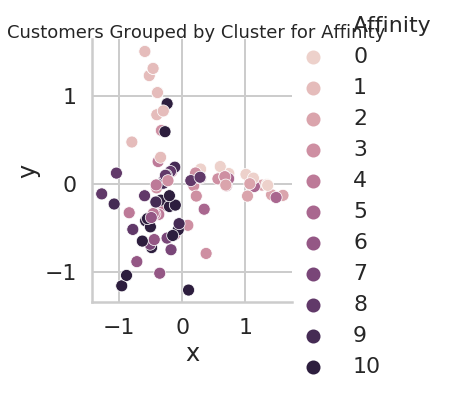

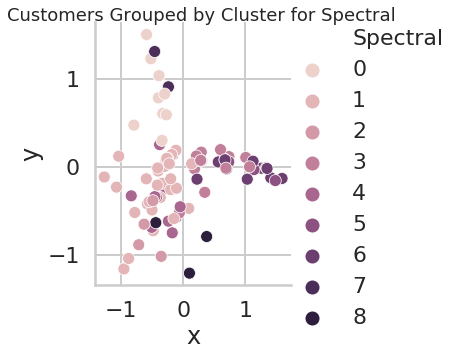

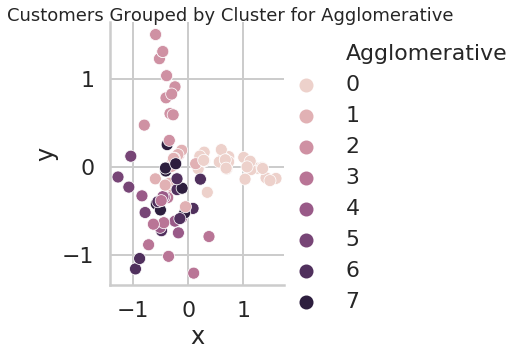

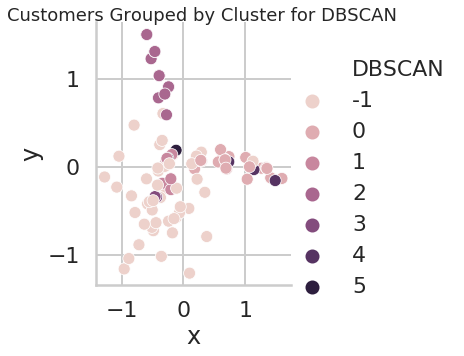

In [11]:
# Your turn
matrix['Affinity'] = AffinityPropagation(damping=0.95, max_iter=1000).fit_predict(matrix[x_cols])
matrix['Spectral'] = SpectralClustering(n_clusters=9).fit_predict(matrix[x_cols])
matrix['Agglomerative'] = AgglomerativeClustering(n_clusters=8, linkage='ward').fit_predict(matrix[x_cols])
matrix['DBSCAN'] = DBSCAN(min_samples=2, eps=1).fit_predict(matrix[x_cols])

# Chart
for algo in ['Affinity', 'Spectral', 'Agglomerative', 'DBSCAN']:
    ax = sns.relplot(x='x', y='y', hue=algo, data=matrix, legend='full')
    ax.fig.suptitle('Customers Grouped by Cluster for ' + algo, fontsize=18)